## 1. Structure Dataset

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt

# funcs stolen from nyu deep learning course
from res.sequential_tasks import pad_sequences, to_categorical
import os

In [2]:
data_path = '/Users/evanrussek/Dropbox/Griffiths_Lab_Stuff/Data/RNNs/optimal_fixation_sims'
# os.path.join(to_save_folder, file_name)
train_file_idxs = range(1,16)
test_file_idxs = range(16,31)

train_files = [os.path.join(data_path, str(i) + '.json') for i in train_file_idxs]
test_files = [os.path.join(data_path, str(i) + '.json') for i in test_file_idxs]

a = [json.load(open(train_files[i])) for i in range(15)]
train_trials = [item for sublist in a for item in sublist]
del a
train_data_sim = train_trials[:int(1e6)]

test_trials = json.load(open(train_files[0]))
test_data_sim = test_trials[:int(1e5)]



In [19]:
test_choices = np.array([t['choice'] for t in test_trials])-1

In [20]:
test_choices[:10]

array([0, 2, 0, 1, 2, 2, 1, 2, 2, 1])

In [3]:
def gen_batch_data(batch_size, batch_idx, sim_data,include_choice=False):

#sim_data = train_data_sim
#batch_idx = 0
#batch_size = 32

    """
    Create sequence and target data for a batch

    Input: 
        batch_size: number of trials to include in batch
        batch_idx: index of data
        sim_data: list of dicts, where each dict has 'values', 'fixations', and 'choice'

    Returns:
        a tuple, (batch_data, batch_targets)
        batch_data is 3d array: batch_size x sequence_size x one-hot categorical encoding (3 here)
        batch_targets is 2d array: 
    """

    # filter list of trials that are in this batch
    batch_sim_data = sim_data[batch_idx*batch_size:((batch_idx+1)*(batch_size))]

    ## generate sequences of fixations + choice

    # all sequences in the batch, attended item is coded as idx (as 0, 1, 2)
    if include_choice:
        batch_sequences_idx = [trial_data['fixations'] + [trial_data['choice']-1] for trial_data in batch_sim_data]
    else:
        batch_sequences_idx = [trial_data['fixations'] for trial_data in batch_sim_data]

    # all sequences in the batch, attended item coded as one-hot categorical: e.g. 0: [1,0,0] 1: [0,1,0], [0,0,1]
    batch_sequences_cat = [[to_categorical(x, num_classes = 3) for x in this_sequence] for this_sequence in batch_sequences_idx]

    # pad front of each sequence with n x [0,0,0] so that all seqeunces are same length
    batch_data = pad_sequences(batch_sequences_cat)
    batch_data = batch_data.astype('float32')


    ## generate sequences of targets
    batch_targets = np.array([trial_data['value'] for trial_data in batch_sim_data], dtype = 'float32')

    return (batch_data, batch_targets)

In [4]:
example_batch = gen_batch_data(32, 0, train_data_sim) # batch size = 32, idx = 0
print(f'The return type is a {type(example_batch)} with length {len(example_batch)}.')
print(f'The first item in the tuple is the batch of sequences with shape {example_batch[0].shape}.')
print(f'The first element in the batch of sequences is:\n {example_batch[0][0, :, :]}')
print(f'The second item in the tuple is the corresponding batch of targets with shape {example_batch[1].shape}.')
print(f'The first element in the batch of targets is:\n {example_batch[1][0, :]}')


The return type is a <class 'tuple'> with length 2.
The first item in the tuple is the batch of sequences with shape (32, 84, 3).
The first element in the batch of sequences is:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 

## 2. Defining the Model

In [5]:
import torch
import torch.nn as nn

# Set the random seed for reproducible results
torch.manual_seed(1)

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        # This just calls the base class constructor
        super().__init__()
        # Neural network layers assigned as attributes of a Module subclass
        # have their parameters registered for training automatically.
        self.rnn = torch.nn.RNN(input_size, hidden_size, nonlinearity='relu', batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # The RNN also returns its hidden state but we don't use it.
        # While the RNN can also take a hidden state as input, the RNN
        # gets passed a hidden state initialized with zeros by default.
        h = self.rnn(x)[0]
        x = self.linear(h)
        return x
    
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

## 3. Defining the Training Loop

In [6]:
def train(model, train_sim_data, criterion, optimizer, device, batch_size, n_total_seq):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        #y_pred = output.argmax(dim=1)
        
        # this is wrong since we're doing regression...
        #num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    return loss.item()

## 4. Defining the Testing Loop

In [7]:
# Define the testing loop
def test(model, test_sim_data, criterion, device, batch_size, n_total_seq):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0
    
    n_total_seq = 1000

    n_batches = int(np.round(n_total_seq / batch_size));

    loss_res = np.zeros((n_batches, 1), dtype=float)

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            # target = target.argmax(dim=1)
            loss = criterion(output, target)  # is this just for the last batch?

            # store the loss
            loss_res[batch_idx] = loss.item()

            # y_pred = output.argmax(dim=1)
            # num_correct += (y_pred == target).sum().item()

    # return num_correct, loss.item()
    # print(loss_res)
    # print(loss.item())

    return np.mean(loss_res)  # loss.item()

In [8]:
from IPython import display
from IPython.display import clear_output


def train_with_int_tests(model, train_sim_data, test_sim_data, criterion, optimizer, device, batch_size, n_total_seq, model_name = ""):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()
    


    # What metric to store?
    # num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
        
    # how many batches
    n_batches = int(np.round(n_total_seq/batch_size));
    
    loss_res = []
    train_loss_res = []

    for batch_idx in range(n_batches):

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        #data, target = train_data_gen[batch_idx] # just alter this to the function that produces the data?
        data, target = gen_batch_data(batch_size, batch_idx, train_sim_data)
        
        data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        
        # for some reason target is an int, and dosn't match the output which is float32
        target = target.to(torch.float32)
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤
        
        if ((batch_idx % 250) == 0) & (batch_idx > 100):
            test_loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq)
            loss_res.append(test_loss)
            
            train_loss_res.append(loss.item())
                        
            clear_output(wait=False)
            plt.figure(figsize=(5,5))
            plt.plot(np.arange(1,len(loss_res)+1)*500*32, loss_res)
            #plt.plot(range(len(train_loss_res)), train_loss_res)
            plt.xlabel('# train examples')
            plt.ylabel('MSE')
            plt.title(model_name)
            plt.show();

            print('batch num' + str(batch_idx) + ' loss: ' + str(test_loss))


    #return num_correct, loss.item()
    return model, loss_res#loss.item()

In [9]:
def train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = ''):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    # history_train = {'loss': [], 'acc': []}
    # history_test = {'loss': [], 'acc': []}
    
    history_train = {'loss': []}
    history_test = {'loss': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        #num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        loss = train(model, train_data_sim, criterion, optimizer, device, batch_size, n_total_seq)
        # accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        # history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        # num_correct, loss = test(model, test_data_gen, criterion, device)
        loss = test(model, test_data_sim, criterion, device, batch_size, n_total_seq)
        history_test['loss'].append(loss)

        if (verbose & (epoch % 1 == 0)) or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f} (MSE)"
                  f" - test_loss: {history_test['loss'][-1]:.4f} (MSE)")

    # Generate diagnostic plots for the loss and accuracy
    fig, ax = plt.subplots(1, figsize=(4.4, 4.5))
    #for ax, metric in zip(axes, ['loss', 'acc']):
    ax.plot(history_train['loss'])
    ax.plot(history_test['loss'])
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel('loss (MSE)', fontsize=12)
    ax.legend(['Train', 'Test'], loc='best')
    ax.set_title(model_name)
    plt.show()

    return model

## Run the RNN!

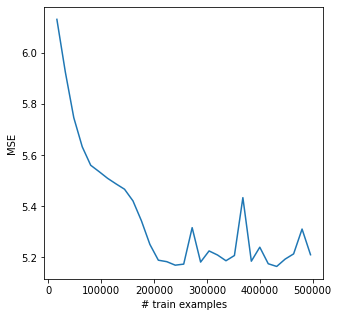

batch num15500 loss: 5.210528250663511
--- 141.1574559211731 seconds ---


In [86]:
import time

# Setup the training and test data generators
batch_size     = 32
n_total_seq = 5e5

# Setup the RNN and training settings
input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = 4
output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
model       = SimpleRNN(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 10

# Train the model
# model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)

start_time = time.time()
model_RNN = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq)
print("--- %s seconds ---" % (time.time() - start_time))


## Run the LSTM

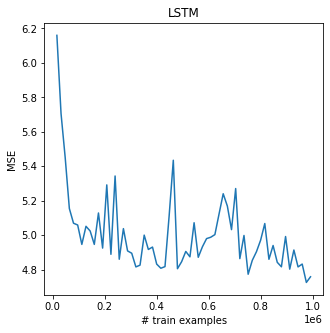

batch num15500 loss: 4.759158488242857
--- 367.8654839992523 seconds ---


In [10]:
import time

# Setup the training and test data generators
batch_size     = 32
n_total_seq = 5e5

# Setup the RNN and training settings
input_size  = 3 # this is the length of the input vector? #train_data_gen.n_symbols
hidden_size = 50
output_size = 3 # this is the leågth of the output vector #train_data_gen.n_classes
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss() # torch.nn.CrossEntropyLoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
# optimizer   = torch.optim.Adam(model.parameters(), lr=0.00304)
max_epochs  = 10

# Train the model›
# model = train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs)
start_time = time.time()
# model_LSTM = train_and_test(model, train_data_sim, test_data_sim, criterion, optimizer, max_epochs, batch_size, n_total_seq, verbose=True, model_name = 'LSTM')
device = torch.device('cpu')#torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_LSTM = train_with_int_tests(model, train_data_sim, test_data_sim, criterion, optimizer, device, batch_size, n_total_seq, model_name='LSTM')

print("--- %s seconds ---" % (time.time() - start_time))

In [11]:
def test_record_each_output(model, test_sim_data, criterion, device, batch_size, n_total_seq):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    # num_correct = 0

    n_batches = int(np.round(n_total_seq/batch_size));

    output_all = np.zeros((0,3))
    target_all = np.zeros((0,3))


    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for batch_idx in range(n_batches):
            data, target = gen_batch_data(batch_size, batch_idx, test_sim_data)
            data, target = torch.from_numpy(data).float().to(device), torch.from_numpy(target).long().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            output_all = np.concatenate((output_all, output.numpy()))
            target_all = np.concatenate((target_all, target.numpy()))

    return (output_all, target_all)

        #target = target.argmax(dim=1)
        #loss = criterion(output, target)

            # y_pred = output.argmax(dim=1)
            # num_correct += (y_pred == target).sum().item()

    #return num_correct, loss.item()
    #return loss.item()

In [101]:
output_all_RNN, target_all_RNN = test_record_each_output(model_RNN, test_data_sim, criterion, device, batch_size, n_total_seq)
fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(target_all_RNN.flatten(), output_all_RNN.flatten(), 'o')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted value')
ax.set_title('RNN performance')

AttributeError: 'tuple' object has no attribute 'eval'

Text(0.5, 1.0, 'LSTM performance')

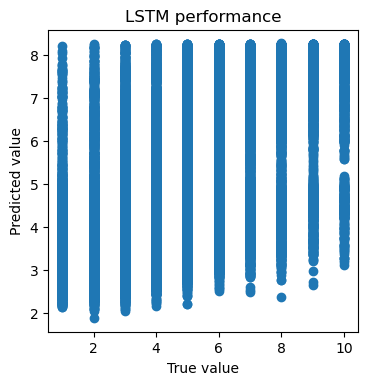

In [93]:
n_total_seq_vis = 1e4

output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM[0], test_data_sim, criterion, device, batch_size, n_total_seq_vis)
fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(target_all_LSTM.flatten(), output_all_LSTM.flatten(), 'o')
ax.set_xlabel('True value')
ax.set_ylabel('Predicted value')
ax.set_title('LSTM performance')

Text(0.5, 1.0, 'LSTM Performance, MSE: 4.94 , r: 0.49 ')

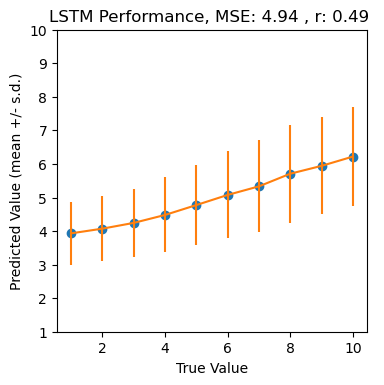

In [12]:
n_total_seq_vis = 1e4
output_all_LSTM, target_all_LSTM = test_record_each_output(model_LSTM[0], test_data_sim, criterion, device, batch_size, n_total_seq_vis)
output_flat = output_all_LSTM.flatten()
target_flat = target_all_LSTM.flatten()

r = np.round(np.corrcoef(output_flat, target_flat)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(output_flat - target_flat,2)), decimals=2)
target_flat_round = np.round(target_flat)
mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(1,11):
    mean_estimates[i-1] = np.mean(output_flat[target_flat_round == i])
    std_estimates[i-1] = np.std(output_flat[target_flat_round == i])

fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(range(1,11), mean_estimates, 'o')
ax.errorbar(range(1,11), mean_estimates, yerr = std_estimates)
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value (mean +/- s.d.)')
ax.set_title('LSTM Performance, MSE: {} , r: {} '.format(mse,r))

### Does it get the correct ordering?

In [117]:
output_max_item = output_all_LSTM.argmax(axis=1)
target_max_item = target_all_LSTM.argmax(axis=1)
pct_correct_max = np.sum(output_max_item == target_max_item)/len(output_max_item)


print('LSTM guesses correct max {}% of trials'.format(100*np.round(pct_correct_max,decimals=2)))

output_min_item = output_all_LSTM.argmin(axis=1)
target_min_item = target_all_LSTM.argmin(axis=1)
pct_correct_min = np.sum(output_min_item == target_min_item)/len(output_min_item)

print('LSTM guesses correct min {}% of trials'.format(100*np.round(pct_correct_min,decimals=2)))

LSTM guesses correct max 73.0% of trials
LSTM guesses correct min 52.0% of trials


In [15]:
# for targets 
target_orders = np.ones(target_all_LSTM.shape)
target_max_item = target_all_LSTM.argmax(axis=1)
target_orders[range(target_orders.shape[0]),target_max_item]=2
target_min_item = target_all_LSTM.argmin(axis=1)
target_orders[range(target_orders.shape[0]),target_min_item]=0

output_orders = np.ones(output_all_LSTM.shape)
output_max_item = output_all_LSTM.argmax(axis=1)
output_orders[range(output_orders.shape[0]),target_max_item]=2
output_min_item = output_all_LSTM.argmin(axis=1)
output_orders[range(target_orders.shape[0]),target_min_item]=0

prop_max_g_mid = np.sum(output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==1])/output_all_LSTM.shape[0]
prop_mid_g_min = np.sum(output_all_LSTM[target_orders==1]>output_all_LSTM[target_orders==0])/output_all_LSTM.shape[0]
prop_max_g_min = np.sum(output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==0])/output_all_LSTM.shape[0]
prop_correct_order = np.sum((output_all_LSTM[target_orders==2]>output_all_LSTM[target_orders==1])&(output_all_LSTM[target_orders==1]>output_all_LSTM[target_orders==0]))/output_all_LSTM.shape[0]

prop_correct_max = np.sum(target_max_item == output_max_item)/len(target_max_item)
prop_correct_min = np.sum(target_min_item == output_min_item)/len(target_min_item)

print('correct order {}% of trials'.format(100*np.round(prop_correct_order,decimals=2)))
print('max > mid {}% of trials'.format(100*np.round(prop_max_g_mid,decimals=2)))
print('mid > min {}% of trials'.format(100*np.round(prop_mid_g_min,decimals=2)))
print('max > min {}% of trials'.format(100*np.round(prop_max_g_min,decimals=2)))
print('correct max {}% of trials'.format(100*np.round(prop_correct_max,decimals=2)))
print('correct min {}% of trials'.format(100*np.round(prop_correct_min,decimals=2)))


correct order 35.0% of trials
max > mid 68.0% of trials
mid > min 60.0% of trials
max > min 76.0% of trials
correct max 60.0% of trials
correct min 51.0% of trials


Text(0.5, 1.0, 'LSTM Performance, No Choice, MSE: 5.61 , r: 0.42 ')

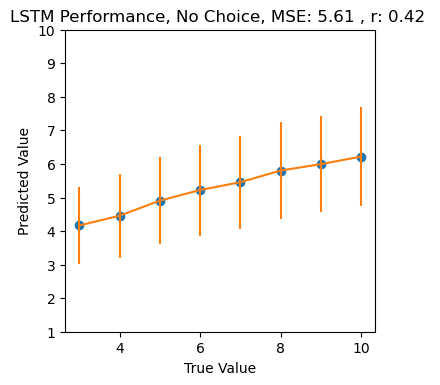

In [14]:
# contains the max index for each trial
max_idxs = np.argmax(target_all_LSTM, axis = 1)
min_idxs = np.argmin(target_all_LSTM, axis = 1)

max_targets = np.round(target_all_LSTM[range(target_all_LSTM.shape[0]), max_idxs])
max_outputs = output_all_LSTM[range(target_all_LSTM.shape[0]), max_idxs]

r = np.round(np.corrcoef(max_outputs, max_targets)[1][0], decimals = 2)
mse = np.round(np.mean(np.power(max_outputs - max_targets,2)), decimals=2)

mean_estimates = np.zeros(10)
std_estimates = np.zeros(10)
for i in range(3,11):
    mean_estimates[i-1] = np.mean(max_outputs[max_targets == i])
    std_estimates[i-1] = np.std(max_outputs[max_targets == i])

fix,ax = plt.subplots(1,figsize = (4,4), dpi = 100)
ax.plot(range(3,11), mean_estimates[2:], 'o')
ax.errorbar(range(3,11), mean_estimates[2:], yerr = std_estimates[2:])
ax.set_ylim([1,10])
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')
ax.set_title('LSTM Performance, No Choice, MSE: {} , r: {} '.format(mse,r))

In [57]:
mean_estimates

array([       nan,        nan, 4.20361695, 4.59310827, 5.12080646,
       5.51035056, 5.77384573, 6.13292855, 6.28513572, 6.52798245])

In [52]:
max_targets

array([4., 7., 4., ..., 4., 3., 8.])

In [47]:
# contains the max index for each trial
max_idxs = np.argmax(target_all_LSTM, axis = 1)
min_idxs = np.argmin(target_all_LSTM, axis = 1)

In [31]:
these_choices = test_choices[:len(max_idxs)]
np.sum(max_idxs == these_choices)/len(these_choices)


0.7280649038461539

In [26]:
test_choices[:these_choices])

(9984,)

In [27]:
test_choices.shape

(118640,)

In [23]:
test_choices

array([0, 2, 0, ..., 1, 0, 1])

In [24]:
max_idxs

array([0, 2, 0, ..., 1, 0, 1])